In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')[:-1]
print(len(train_data), len(test_data))

train= train_data
test = test_data.apply(pd.to_numeric)

68636 29413


In [ ]:
X = train.drop("signal", axis=1)
X = (X-X.mean())/X.std()
train = X.join(train["signal"])

XX = test.drop("signal", axis=1)
XX = (XX-XX.mean())/XX.std()
test = XX.join(test["signal"])

In [3]:
from scipy.stats import ks_2samp
train_stat, train_p = [], []

for i in range(len(train.keys())-1):
    train_stat = np.append(train_stat,ks_2samp(train.query('signal==0')[train.keys()[i]],train.query('signal==1')[train.keys()[i]])[0])
    train_p = np.append(train_stat,ks_2samp(train.query('signal==0')[train.keys()[i]],train.query('signal==1')[train.keys()[i]])[1])


train_list = dict(zip(train.keys()[:-1],train_stat))
train_list_sorted = dict(sorted(train_list.items(), key=lambda item: item[1]))
train_list_sorted


{'missing_energy_phi': 0.003254063696343179,
 'lepton_phi': 0.005250537605601402,
 'jet1phi': 0.006744408012343661,
 'jet3phi': 0.007694254995927352,
 'jet4phi': 0.008105746088170163,
 'jet2phi': 0.008137114722488237,
 'm_lv': 0.010386893995635749,
 'lepton_eta': 0.010518898163357937,
 'jet1b.tag': 0.012580087397600026,
 'jet3pt': 0.012693279584993333,
 'jet1eta': 0.014007216717948245,
 'jet3eta': 0.014504340101392843,
 'jet4b.tag': 0.015875851281828557,
 'jet2eta': 0.0173633309139285,
 'm_jj': 0.017681132670639033,
 'jet4eta': 0.019486671326037097,
 'jet3b.tag': 0.02494816071865935,
 'jet2pt': 0.02846273239147512,
 'jet4pt': 0.030942537809816595,
 'lepton_pT': 0.03858265522652582,
 'jet2b.tag': 0.049864347970956235,
 'm_jlv': 0.05341320850942499,
 'jet1pt': 0.06990101266799159,
 'missing_energy_magnitude': 0.07262518556598518,
 'm_jjj': 0.09632140613997875,
 'm_wbb': 0.1070652762675185,
 'm_wwbb': 0.1517473764300511,
 'm_bb': 0.1960046638615971,
 'signal': 1.0}

In [4]:
def act_f(xvals):
    return 1/(1+np.exp(-xvals))
    #return np.exp(-xvals**2)
    
def f_cost(y, xvals):
    return (1/2) * (y - xvals)**2

def der_f_act(xvals):
    return np.exp(-xvals)/(1+np.exp(-xvals))**2
    #return -2*xvals*np.exp(-xvals**2)
    
def der_f_cost(y, xvals):
    return -(y - xvals)

In [106]:
#np.random.seed(12)
def bias_vector(n_nodes):
    return np.array(np.random.uniform(-1,1,n_nodes))
    #return np.ones(n_nodes)

def initialize_all_bias(n_hidden_nodes,n_hidden_layers):
    all_bias_nodes = []
    for _ in range(n_hidden_layers):
        all_bias_nodes.append(bias_vector(n_hidden_nodes))
    all_bias_nodes.append(bias_vector(1))
    
    return all_bias_nodes
    
def init_weight_mat(n_next,n_previous):
    #return np.array(np.random.uniform(-1,1,[n_next,n_previous]))
    return np.array(np.random.uniform(-np.sqrt(6/(n_previous+n_next)),np.sqrt(6/(n_previous+n_next)),[n_next,n_previous]))
    #return np.ones([n_next,n_previous])


def initialize_all_weight_matrices(n_input_features, n_hidden_nodes, n_hidden_layers):
    
    list_of_nodes = [n_input_features]
    for _ in range(n_hidden_layers):
        list_of_nodes.append(n_hidden_nodes)
    list_of_nodes.append(1)
    
    all_weight_matrices = []
    for i in range(len(list_of_nodes)-1):
        all_weight_matrices.append(init_weight_mat(list_of_nodes[i+1],list_of_nodes[i]))

    #[number of inputs][number of hidden nodes][number of input layers]
    return all_weight_matrices

def input_sum(weights, inputs, bias):
    return np.dot(weights,inputs) + bias



In [107]:
def forward_prop(input_features, n_hidden_nodes, n_hidden_layers, weight_list_dummy, bias_list_dummy):

    
    x_list = input_features
    z_list, act_z_list = [], []

    for layer in range(len(weight_list_dummy)):
        
        z_list.append((np.dot(weight_list_dummy[layer], x_list).transpose() + bias_list_dummy[layer]).transpose())
        act_z_list.append(act_f(np.dot(weight_list_dummy[layer], x_list).transpose() + bias_list_dummy[layer]).transpose())

        x_list = act_z_list[-1]
    act_z_list.insert(0,np.array(input_features))
    
    
    
    # for 1st two vars :[# var][layer number][node number][data number]            
    return z_list, act_z_list, weight_list_dummy, bias_list_dummy

In [108]:
# function to initialize errors for each node (set to 0 at start)
def initialize_node_error(n_hidden_nodes,n_hidden_layers):
    all_nodes = []
    for _ in range(n_hidden_layers):
        all_nodes.append([0] * n_hidden_nodes)
    all_nodes.append([0])
    
    return all_nodes
    
def back_prop(true_values, z_list, act_z_list, weight_list, bias_list, input_features, lambda_reg):
    
    cost_cal = np.sum(f_cost(true_values, act_z_list[-1]))
    output_error = der_f_cost(true_values, act_z_list[-1][0]) 
    lrate = 2 / len(true_values)
    
    # to store weights...
    #weight_epochs, bias_epochs = []
    #weight_epochs.append(weight_list)
    #bias_epochs.append(bias_list)
    
    # np.shape(weight_list[1])[1] = no. of hidden nodes
    # len(weight_list[:-1]) = no. of hidden layers
    
    error_node_matrix = initialize_node_error(np.shape(weight_list[-1])[1], len(weight_list[:-1]))

    error_node_matrix[-1][0] = output_error * der_f_act(z_list[-1][0])

    for layer in range(len(weight_list)-1,0,-1): 
        
        for node in range(np.shape(weight_list[layer])[1]):
            
            for each_weight in range(np.shape(weight_list[layer][0])[0]): 
                
                if layer==len(weight_list)-1:
 
                    error_node_matrix[layer-1][node] +=( weight_list[layer][0][each_weight] * 
                                                      error_node_matrix[layer][0] * 
                                                      der_f_act(z_list[layer-1][node]) )
                    
                if layer<len(weight_list)-1:
                
                    error_node_matrix[layer-1][node] +=( weight_list[layer][each_weight][node] * 
                                                      error_node_matrix[layer][each_weight] * 
                                                      der_f_act(z_list[layer-1][node]) )
 
    
    for layer in range(len(weight_list)):    
        
        for node in range(np.shape(weight_list[-layer-1])[0]):
            
            for each_weight in range(np.shape(weight_list[-layer-1][node])[0]):
                    
                if layer!=(len(weight_list)-1):
                    
                    weight_list[-layer-1][node][each_weight] -= np.sum(lrate * act_z_list[-layer-2][each_weight] *
                                                          error_node_matrix[-layer-1][node])
                    
                if layer==(len(weight_list)-1):
                    #weight_list[-layer-1][node][each_weight] -= np.sum(lrate * input_features[each_weight] *
                    #                                      error_node_matrix[-layer-1][node]) 
                    
                    weight_list[-layer-1][node][each_weight] -= (np.sum(lrate * input_features[each_weight] *
                                                          error_node_matrix[-layer-1][node]) 
                                                    + lambda_reg * lrate * weight_list[-layer-1][node][each_weight])                    
                
                bias_list[-layer-1][node] -=  np.sum(lrate * error_node_matrix[-layer-1][node])
                    
    
    return weight_list, bias_list, cost_cal

def train_network(input_features, n_hidden_nodes, n_hidden_layers, true_values,epochs, lambda_reg):
    
    print("Will run upto:", epochs)
    
    weight_list = initialize_all_weight_matrices(len(input_features), n_hidden_nodes, n_hidden_layers)
    bias_list = initialize_all_bias( n_hidden_nodes, n_hidden_layers)
    cost_all = np.array([])
    for epochs_i in range(epochs):
        z_list_i, act_z_list_i, weight_list_i, bias_list_i = forward_prop(input_features, n_hidden_nodes, 
                                                                          n_hidden_layers, weight_list, bias_list)
        
        weights_updated, bias_updated, cost_dum = back_prop(true_values, z_list_i, act_z_list_i, weight_list_i, 
                                                  bias_list_i, input_features, lambda_reg)
        weight_list_i = weights_updated
        bias_list_i = bias_updated
        
        cost_all = np.append(cost_all,cost_dum)
        print(epochs_i+1, end=" ")
        
        
    return weights_updated, bias_updated, cost_all

In [111]:
#d_index = 5
#input_vector = np.array([train['m_bb'][:d_index],train['m_wwbb'][:d_index],train['m_wbb'][:d_index]])
input_vector = np.array([train['m_bb'],train['m_wwbb'],train['m_wbb']])
#true_vector = np.array(train['signal'][:d_index])
true_vector = np.array(train['signal'])

all_arr = train_network(input_vector,5,1,true_vector,2000, lambda_reg = 0)



Will run upto: 2000


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 

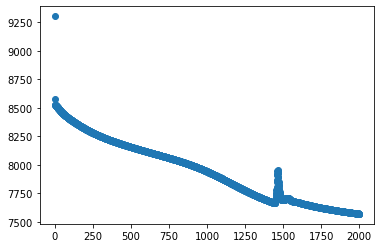

In [112]:
plt.scatter(np.arange(0,len(all_arr[2]),1),all_arr[2])
plt.show()

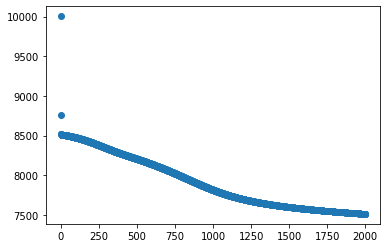

In [90]:
plt.scatter(np.arange(0,len(all_arr[2]),1),all_arr[2])
plt.show()

In [113]:
def test_network(input_test_vector, weights_trained, bias_trained):
    
    x_test_list = input_test_vector
    z_test_list, act_z_test_list = [], []     
    for layer in range(len(weights_trained)):

        z_test_list.append((np.dot(weights_trained[layer], x_test_list).transpose() + bias_trained[layer]).transpose())
        act_z_test_list.append(act_f(np.dot(weights_trained[layer], x_test_list).transpose() + bias_trained[layer]).transpose())

        x_test_list = act_z_test_list[-1]
    act_z_test_list.insert(0,np.array(input_test_vector))
    
    # for 1st two vars :[# var][layer number][node number][data number]            
#    return z_test_list, act_z_test_list
    return act_z_test_list[-1][0]




In [114]:
test_vector = np.array([test['m_bb'],test['m_wwbb'],test['m_wbb']])

test_output = test_network(test_vector,all_arr[0],all_arr[1])

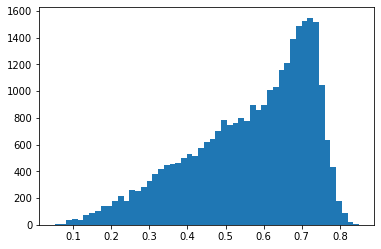

In [115]:
plt.hist(test_output,bins='auto')

plt.show()

ROC score for  m_bb 0.5538334386750075
ROC score for  m_wwbb 0.567830783780928
ROC score for  m_wbb 0.5171133577631016
ROC score for  ANN output 0.706529813502885


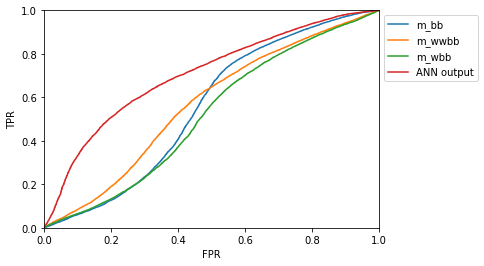

0.706529813502885

In [116]:
feats = ['m_bb','m_wwbb','m_wbb']#,'m_jjj']

from sklearn.metrics import roc_curve, roc_auc_score, auc

def left_right_ordered_feature(sample, f):
    mean_sig = np.mean(sample[f][sample["signal"] == 1])
    mean_bkg = np.mean(sample[f][sample["signal"] == 0])
    if mean_bkg < mean_sig:
        return sample[f]
    else:
        return -sample[f]

for label,value in [(f, left_right_ordered_feature(test, f)) for f in feats]+[("ANN output", test_output)]:
    fpr, tpr, thresh = roc_curve(test["signal"], value)
    
    #plt.plot(tpr, 1-fpr, label=label)
    plt.plot(fpr, tpr, label=label)
    print("ROC score for ",label,roc_auc_score(test["signal"], value))

plt.xlim(0,1)
plt.ylim(0,1)
#plt.xlabel('signal efficiency')
plt.xlabel('FPR')
#plt.ylabel('background rejection')
plt.ylabel('TPR')
plt.legend(bbox_to_anchor=(1,1), loc="upper left");
plt.show()

auc(fpr,tpr)

In [117]:
test

,signal,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1pt,jet1eta,jet1phi,jet1b.tag,...,jet4phi,jet4b.tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,id
0,1,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487,68637
1,1,1.176566,0.104161,1.397002,0.479721,0.265513,1.135563,1.534831,-0.253291,0.000000,...,0.530334,0.000000,0.833175,0.773968,0.985750,1.103696,0.849140,0.937104,0.812364,68638
2,1,1.384098,0.116822,-1.179879,0.762913,-0.079782,1.019863,0.877318,1.276887,2.173076,...,0.504809,3.101961,0.959325,0.807376,1.191814,1.221210,0.861141,0.929341,0.838302,68639
3,1,1.330110,0.201557,1.173393,0.135309,-1.083159,0.728461,1.109032,-0.539903,1.086538,...,0.054775,3.101961,0.782073,0.672103,0.990002,0.734279,0.379074,0.764760,0.642924,68640
4,0,1.289848,-1.423023,-0.687162,0.131103,-1.135935,0.821350,0.296053,0.167582,2.173076,...,0.727328,0.000000,1.006643,0.867914,0.999090,1.109608,1.125094,0.882899,0.859396,68641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29408,0,0.681892,-2.024935,1.027465,0.739363,-0.547059,0.747515,-1.932954,-0.134101,0.000000,...,-1.458021,3.101961,0.732955,0.819291,0.985703,0.825365,0.365019,0.771479,0.670891,98045
29409,0,1.678010,0.264865,1.207240,0.162353,1.187041,0.485610,-0.023791,0.128222,2.173076,...,0.881594,0.000000,0.893775,0.930790,0.982853,0.837419,0.861734,0.873256,0.773829,98046
29410,1,1.180592,0.678802,1.088500,0.297297,0.165214,0.551476,0.250503,1.405502,0.000000,...,-0.206137,3.101961,0.944666,0.826648,0.990374,1.121632,1.236583,1.062557,0.917057,98047
29411,0,2.786130,-0.679884,-1.673151,0.854033,1.020573,0.844252,-0.323831,-0.132437,0.000000,...,1.054172,0.000000,0.931880,0.880436,1.399047,1.041965,0.875924,1.056742,1.383591,98048


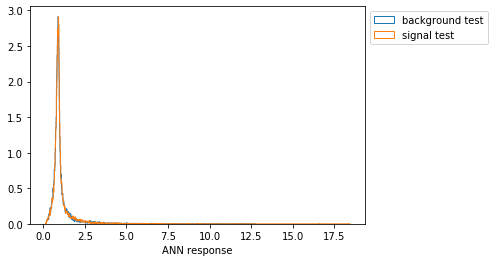

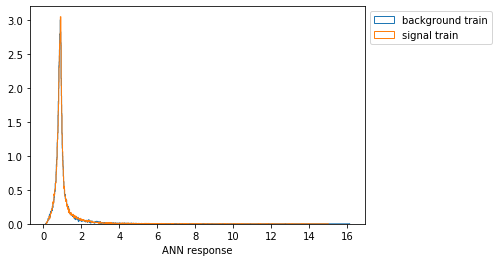

In [118]:
plt_quantity = 'm_jj'
plt.hist(test.query('signal==0')[plt_quantity], label="background test",histtype='step',density=True,bins='auto')
plt.hist(test.query('signal==1')[plt_quantity], label="signal test",histtype='step',density=True,bins='auto')
plt.xlabel("ANN response")
plt.legend(bbox_to_anchor=(1,1), loc="upper left");
plt.show();

plt.hist(train.query('signal==0')[plt_quantity], label="background train",histtype='step',density=True,bins='auto')
plt.hist(train.query('signal==1')[plt_quantity], label="signal train",histtype='step',density=True,bins='auto')
plt.xlabel("ANN response")
plt.legend(bbox_to_anchor=(1,1), loc="upper left");
plt.show();


In [119]:
all_arr[0]

[array([[ 0.14297776, -4.35929015,  2.32277495],
        [-2.10878582, -2.22086451,  3.51591401],
        [ 0.06562087, -2.19430354,  1.01219406],
        [ 6.1337492 , -1.19738705,  1.59985859],
        [-6.16922424,  0.00758963,  1.6670386 ]]),
 array([[2.28046069, 1.95779692, 0.82633905, 2.14550678, 1.71680816]])]

In [120]:
-np.sqrt(6/n_i+n_o),np.sqrt(6/n_i+n_o)



NameError: name 'n_i' is not defined

In [121]:
n_next = 1
n_previosu
np.array(np.random.uniform(-np.sqrt(6/(n_previous+n_next)),np.sqrt(6/(n_previous+n_next)),[n_next,n_previous]))

NameError: name 'n_previosu' is not defined

In [105]:
np.sqrt(6/(n_previous+n_next))

1.0